In [14]:
!python -V

Python 3.12.1


In [15]:
import pandas as pd
import numpy as np

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
import pickle

In [18]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [19]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df["duration"] = df["duration"].apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']

    df[numerical] = df[numerical].astype(float)
    df[categorical] = df[categorical].astype(str)
    
    return df


In [20]:
df_train = read_dataframe('green_tripdata_2021-01.parquet')
df_val = read_dataframe('green_tripdata_2021-02.parquet')

In [21]:
# categorical = ['PULocationID', 'DOLocationID']
# numerical = ['trip_distance']
# categorical + numerical
# output: ['PULocationID', 'DOLocationID', 'trip_distance']

In [ ]:
df_train['PU_DO'] = df_train['PULocationID']+ '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID']+ '_' + df_val['DOLocationID']

categorical = ['PU_DO']
numerical = ['trip_distance']

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
# print('train_dicts: ', train_dicts[0])
# print()

# Create Feature Matrix
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

train_dicts:  {'PU_DO': '43_151', 'trip_distance': 1.01}



In [23]:
X_train[0:5].toarray()

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.01],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 2.53],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.12],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.99],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.45]], shape=(5, 13221))

In [24]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [26]:
# y_train

### Logistic Regression

In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)

y_val_pred = lr.predict(X_val)

# Evaluate the model on test set
mae = mean_absolute_error(y_val, y_val_pred)
mae

5.339713109777427

### Plots

/tmp/ipykernel_132034/3565743134.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_val, label ='actual', shade=True)
/tmp/ipykernel_132034/3565743134.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train_pred, label = 'predicted', shade=True)


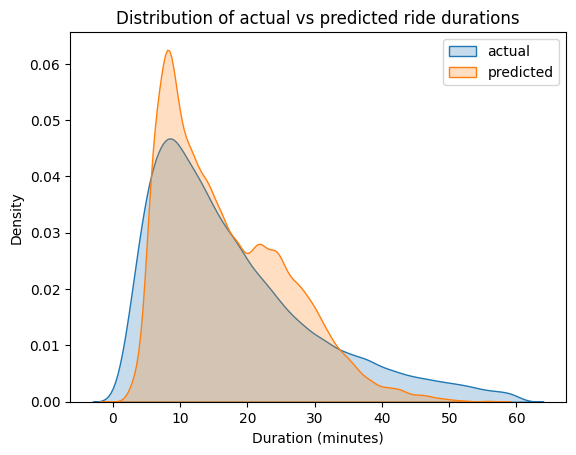

In [35]:
sns.kdeplot(y_val, label ='actual', shade=True)
sns.kdeplot(y_train_pred, label = 'predicted', shade=True)
plt.title('Distribution of actual vs predicted ride durations')
plt.xlabel('Duration (minutes)')
plt.legend()

In [28]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

### Trying out Lasso Regression

In [30]:
la = Lasso(alpha=0.1)
la.fit(X_train, y_train)
y_train_pred = la.predict(X_train)

y_val_pred = la.predict(X_val)

mae = mean_absolute_error(y_val, y_val_pred)
mae

9.328861232704558

In [31]:
with open('models/las_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

### Trying out Ridge Regression

In [32]:
rg = Ridge(alpha=1.0)
rg.fit(X_train, y_train)
y_train_pred = rg.predict(X_train)
y_val_pred = rg.predict(X_val)

mae = mean_absolute_error(y_val, y_val_pred)
mae

5.2089229148561875

In [33]:
with open('models/rid_reg.bin', 'wb') as f_out:
    pickle.dump((dv, rg), f_out)